## Simple Demo Using Historical PV Production Capacity to Predict Short Term Future Capacity

### Training Set:
5 minute interval intraday solar PV power generation of power plants around the world is available on this website.
For example, [an intraday power output dataset of a power plant in sydney](https://pvoutput.org/intraday.jsp?id=31472&sid=28833&dt=20200700&gs=0&m=0)

We scrap the website to gather the data set using urllib and beautiful soup.
Then we serialize the results to a pickle file to speedup re-execution

In [4]:
import pathlib
import urllib.request
from bs4 import BeautifulSoup
import pickle

# 4 days worth of historical solar power output dataset is used for training
pVPowerPlants = [
    {'url': 'https://pvoutput.org/intraday.jsp?id=31472&sid=28833&dt=20200700&gs=0&m=0'},  # Australia/Sydney - 6/30/2020
    {'url': 'https://pvoutput.org/intraday.jsp?id=31472&sid=28833&dt=20200702&gs=0&m=0'},  # Australia/Sydney - 7/1/2020
    {'url': 'https://pvoutput.org/intraday.jsp?id=31472&sid=28833&dt=20200703&gs=0&m=0'},  # Australia/Sydney - 7/2/2020
    {'url': 'https://pvoutput.org/intraday.jsp?id=31472&sid=28833&dt=20200704&gs=0&m=0'},  # Australia/Sydney - 7/3/2020
]
pVPowerPlantsPickleTrainingFile = pathlib.Path('pv-power-plants-training.pickle')
if (pVPowerPlantsPickleTrainingFile.exists()):
    with open(pVPowerPlantsPickleTrainingFile, 'rb') as f:
        pVPowerPlants = pickle.load(f)
else:
    for powerPlantIdx, powerPlant in enumerate(pVPowerPlants):
        print(powerPlant['url'])
        with urllib.request.urlopen(powerPlant['url']) as response:
            jsScript = BeautifulSoup(response.read()).findAll('script')[-2].string
            powerPlant = {}
            for jsScriptLine in jsScript.split(';'):
                jsScriptLine = jsScriptLine.strip()
                if 'var systemName = ' in jsScriptLine:
                    powerPlant['powerPlantName'] = jsScriptLine.split(' = ')[1].replace('\'', '')
                elif 'var timezone = ' in jsScriptLine:
                    powerPlant['timeZone'] = jsScriptLine.split(' = ')[1].replace('\'', '')
                elif 'var lng = ' in jsScriptLine:
                    powerPlant['lng'] = float(jsScriptLine.split(' = ')[1])
                elif 'var lat = ' in jsScriptLine:
                    powerPlant['lat'] = float(jsScriptLine.split(' = ')[1])
                elif 'var cats = ' in jsScriptLine:
                    powerPlant['localTime'] = jsScriptLine.split('[')[1].split(']')[0].replace('\'', '').split(',')
                elif 'var dataPowerOut = ' in jsScriptLine:
                    powerPlant['powerOutput'] = [int(str) for str in jsScriptLine.split('[')[1].split(']')[0].replace('\'', '').split(',')]
            pVPowerPlants[powerPlantIdx] = powerPlant
    pickle.dump(pVPowerPlants, open(pVPowerPlantsPickleTrainingFile, 'wb'))

### Preparing LSTM Training Set Data
For the hackathon, we train the simplest univariate LSTM time series forecasting model.
More complicated and precise models can be easily extended, but is not implemented at this time.

In [5]:
import numpy as np

# Method to split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return X, y

# Generate training dataset using photo voltaic power plant production output values
n_steps = 3
X, y = list(), list()
for pvPowerPlant in pVPowerPlants:
    _X, _y = split_sequence(pvPowerPlant['powerOutput'], n_steps)
    X += _X
    y += _y
X = np.array(X)
y = np.array(y)

print("Number of training samples: " + str(len(X)))

Number of training samples: 594


### After preparing the training samples, we will use it to train a univariate LSTM model using keras

In [6]:
from tensorflow_core.python.keras.models import Sequential
from tensorflow_core.python.keras.layers import LSTM
from tensorflow_core.python.keras.layers import Dense

# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define a basic LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=100, verbose=1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 594 samples
Epoch 1/100
594/594 [==============================] - 1s 1ms/sample - loss: 11316182.2963
Epoch 2/100
594/594 [==============================] - 0s 168us/sample - loss: 9298556.1279
Epoch 3/100
594/594 [==============================] - 0s 141us/sample - loss: 6567942.2542
Epoch 4/100
594/594 [==============================] - 0s 354us/sample - loss: 3614732.3089

### Now that training is done, we will use the model to test our prediction accuracy
We will use the photo voltaic power plant capacity from another day to validate the accuracy

In [29]:
pVPowerPlants = [
    {'url': 'https://pvoutput.org/intraday.jsp?id=31472&sid=28833&dt=20200705&gs=0&m=0'},  # Australia/Sydney - 7/4/2020}
]
pVPowerPlantsPickleValidationFile = pathlib.Path('pv-power-plants-validation.pickle')
if (pVPowerPlantsPickleValidationFile.exists()):
    with open(pVPowerPlantsPickleValidationFile, 'rb') as f:
        pVPowerPlants = pickle.load(f)
else:
    for powerPlantIdx, powerPlant in enumerate(pVPowerPlants):
        print(powerPlant['url'])
        with urllib.request.urlopen(powerPlant['url']) as response:
            jsScript = BeautifulSoup(response.read()).findAll('script')[-2].string
            powerPlant = {}
            for jsScriptLine in jsScript.split(';'):
                jsScriptLine = jsScriptLine.strip()
                if 'var systemName = ' in jsScriptLine:
                    powerPlant['powerPlantName'] = jsScriptLine.split(' = ')[1].replace('\'', '')
                elif 'var timezone = ' in jsScriptLine:
                    powerPlant['timeZone'] = jsScriptLine.split(' = ')[1].replace('\'', '')
                elif 'var lng = ' in jsScriptLine:
                    powerPlant['lng'] = float(jsScriptLine.split(' = ')[1])
                elif 'var lat = ' in jsScriptLine:
                    powerPlant['lat'] = float(jsScriptLine.split(' = ')[1])
                elif 'var cats = ' in jsScriptLine:
                    powerPlant['localTime'] = jsScriptLine.split('[')[1].split(']')[0].replace('\'', '').split(',')
                elif 'var dataPowerOut = ' in jsScriptLine:
                    powerPlant['powerOutput'] = [int(str) for str in jsScriptLine.split('[')[1].split(']')[0].replace('\'', '').split(',')]
            pVPowerPlants[powerPlantIdx] = powerPlant
    pickle.dump(pVPowerPlants, open(pVPowerPlantsPickleValidationFile, 'wb'))

# Generate validation set input
X_validation, y_validation = list(), list()
for pvPowerPlant in pVPowerPlants:
    _X_validation, _y_validation = split_sequence(pvPowerPlant['powerOutput'], n_steps)
    X_validation += _X_validation
    y_validation += _y_validation
X_validation = np.array(X_validation)
y_validation = np.array(y_validation)

# Note: We only use X_validation for prediction. y_validation is the true value
power_generation_prediction = model.predict(X_validation.reshape((len(X_validation), n_steps, n_features)), verbose=0)

# np.set_printoptions(suppress=True)
# print(power_generation_prediction)


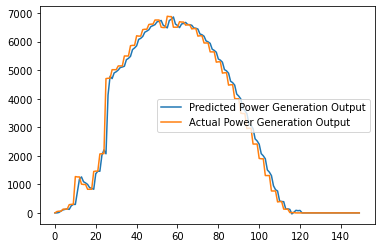

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(power_generation_prediction, label="Predicted Power Generation Output")
plt.plot(y_validation, label="Actual Power Generation Output")
plt.legend(loc='best')
plt.show()

### Summary
As observed, a simple LSTM model trained using historical power generation dataset from the same power plant 
can predicting short term power generation capacity fairly well.